In this homework, we will use the Car price dataset like last week. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv).

Or you can do it with `wget`:

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
```


In [1]:
! wget -nc https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv


File ‘data.csv’ already there; not retrieving.




We'll work with the `MSRP` variable, and we'll transform it to a classification task. 

For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


In [2]:
import pandas as pd

df = pd.read_csv('data.csv')

In [3]:
columns_to_use = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]
df = df[columns_to_use]

### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [4]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df.fillna(0)
df = df.rename(columns={'msrp': 'price'})
df['above_average'] = df['price'].apply(lambda x: 1 if x > df['price'].mean() else 0)


In [5]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(7148, 2383, 2383)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [10]:
y_train = df_train.above_average.values
y_val = df_val.above_average.values
y_test = df_test.above_average.values

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [18]:
from sklearn.metrics import auc, roc_curve, roc_auc_score

categorical = ['make', 'model', 'transmission_type', 'vehicle_style']
numerical =  ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']

for col in numerical:
    roc_score = roc_auc_score(df_train.above_average, df_train[col])
    if roc_score < 0.5:
        roc_score = roc_auc_score(df_train.above_average, -df_train[col])
    print(f'roc_score is {roc_score} for {col}')

roc_score is 0.687551492804683 for year
roc_score is 0.9171031265539011 for engine_hp
roc_score is 0.766116490165669 for engine_cylinders
roc_score is 0.6330587871772013 for highway_mpg
roc_score is 0.6734244643245233 for city_mpg


### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [21]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

q2_score = roc_auc_score(y_val, y_pred).round(3)

q2_score - 0.878, 0.979 - q2_score

(0.040000000000000036, 0.06099999999999994)

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88


precision and recall curves intersect at 0.48


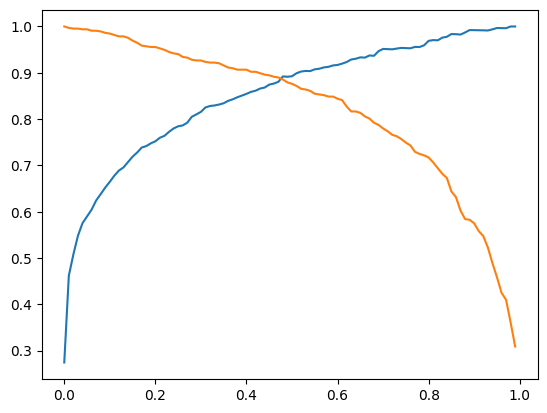

In [40]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
thresholds = np.arange(0, 1, 0.01)
y_pred = model.predict_proba(X_val)[:, 1]
precisions = []
recalls = []
min_diff = 1

for t in thresholds:

    ps = precision_score(y_val, (y_pred >= t))
    rs = recall_score(y_val, (y_pred >= t))
    precisions.append(ps)
    recalls.append(rs)
    diff = np.abs(ps - rs)
    if  diff < min_diff:
        min_diff = diff
        min_threshold = t
    if ps == rs:
        print(f'presicion equals recall at t = {t}')

plt.plot(thresholds, precisions)
plt.plot(thresholds, recalls)
print(f'precision and recall curves intersect at {min_threshold}')

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [ ]:
### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.